<a href="https://colab.research.google.com/github/zudanievil/MiceBrainMriSegmentation/blob/paper/ipynb/example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open this notebook in Google Colab"/></a>

This notebook runs in Google Colab with no prior setup.

You can also run it on a local python installation, but you will need to change some CAPITAL_CASE constants.

# Mice Brain Mri Segmentation #
(actually, it can segment human scans as well. the repo name is a bit underthought)

## Overview ##
* These scripts allow to finenly segment raster images (MRI scans) using svg images (from histological brain atlas).
* Atlas svg images and some other assets are retrieved from Allen Brain Institute web-service, which is free for academic and personal use.
    * [Allen Brain Institute website](https://portal.brain-map.org/)
    * [Mouse | Human brain atlases](http://atlas.brain-map.org/)
    * [Allen Brain Institute API help](http://help.brain-map.org/display/api/Allen+Brain+Atlas+API)
* This repository contains a collection of cohesive scripts, **not a Python package or an application**. One should know Python to use this.


This notebook will guide through one through the demonstration of repo concept:
1. [setup](#1.-Setup)
1. [creating folders](#2a.-creating-folders) and nessesary files
1. [manually segmenting the brains from the scans](#3.-manual-scan-segmentation)
1. [bulk-downloading atlas images](#4a.-downloading-atlas-images) and generating raster masks from them
1. [preprocessing scans before fine segmentation](#5.-preprocessing-scans)
1. [fine-segmenting brains into anatomical regions](#6.-fine-anatomical-segmentation)
1. [postprocessing segmentation results](#7.-aftermath)

## 1. Setup
You don't need anything to run this in Google Colab.

To run this on a local machine:
1. clone this repository
1. install [Anaconda] package manager
1. [create virtual environment from the file] named `conda_env.yml` contained in this repository
1. install [Inkscape], install [ImageJ]
1. it is best to install [PyCharm] for code editing, and [set up PyCharm to use Anaconda virtual environment]
1. edit some CAPITAL_CASE constants in this notebook (see Constants section below)

[Anaconda]: https://www.anaconda.com/products/individual
[create virtual environment from the file]: https://docs.conda.io/projects/conda/en/latest/user-guide/tasks/manage-environments.html#creating-an-environment-from-an-environment-yml-file
[PyCharm]: https://www.jetbrains.com/pycharm/download/
[set up PyCharm to use Anaconda virtual environment]: https://www.jetbrains.com/help/pycharm/conda-support-creating-conda-virtual-environment.html
[Inkscape]: https://inkscape.org/
[ImageJ]: https://imagej.nih.gov/ij/download.html


### imports & utility functions

In [79]:
import sys
from pathlib import Path
import itertools

import yaml
from shutil import copy as file_copy
from urllib.request import urlretrieve
from zipfile import ZipFile

import matplotlib.pyplot as plt
from matplotlib.image import imread
import pandas as pd

In [2]:
# @markdown some generic utility functions, used throughout the notebook

# @markdown `def unzip(src: Path, dst: Path)`
def unzip(src: Path, dst: Path):
    """unzip a `.zip file located at `src` into `dst` folder"""
    with ZipFile(src, 'r') as z:
        z.extractall(dst)
    
# @markdown `def rmdir_rec(folder: Path)`
def rmdir_rec(folder: Path): #why didn't they implement it in the pathlib?
    """removes `folder` with all the contents"""
    for f in folder.iterdir():
        rmdir_rec(f) if f.is_dir() else f.unlink()
    folder.rmdir()
    
# @markdown `def merge_folders(src: Path, dst: Path, matching_files_policy: {"skip", "replace", "rename", "error"} = "replace")`    
def merge_folders(src: Path, dst: Path, matching_files_policy: {"skip", "replace", "rename", "error"} = "replace"):
    """
    recursively copies contents from the `src` folder to `dst` folder.
    if files match, uses `matching_files_policy`:
        - skip
        - replace
        - error: raises FileExistsError
        - rename: adds ".copy" suffix to filename, eg `a.txt` -> `a.copy.txt`
    """
    assert matching_files_policy in {"skip", "replace", "rename", "error"}
    
    for path_src in src.iterdir():
        path_dst = dst / path_src.name
        if path_src.is_dir():
            path_dst.mkdir(exist_ok=True)
            merge_folders(path_src, path_dst, matching_files_policy)
        else:
            if path_dst.exists():
                if matching_files_policy == "error":
                    raise FileExistsError(path_dst)
                elif matching_files_policy == "replace":
                    path_dst.unlink()
                elif matching_files_policy == "rename":
                    while path_dst.exists():
                        path_dst = path_dst.parent / (path_dst.stem + ".copy" + path_dst.suffix)
                else:
                    continue
            file_copy(path_src, path_dst)

# @markdown `def fetch_unpack_zip(url: str, dst: Path) -> "http message"`
def fetch_unpack_zip(url: str, dst: Path) -> "http message":
    """
    fetches example data from the cloud, 
    :returns http.client.HTTPMessage
    """
    zip, msg = urlretrieve(url)
    zip = Path(zip)
    unzip(src=zip, dst=dst)
    zip.unlink()
    return msg

# @markdown `def fetch_github_repo(user: str, repo: str, branch: str, dst_dir: Path, compression: {"zipball", "tarball"} = "zipball",) -> (str, "http message")`
def fetch_github_repo(
    user: str, repo: str, branch: str, 
    dst_dir: Path, compression: {"zipball", "tarball"} = "zipball",
) -> (str, "http message"):
    url = f"https://api.github.com/repos/{user}/{repo}/{compression}/{branch}" 
    # https://docs.github.com/en/rest/reference/repos#download-a-repository-archive-tar
    dst_dir = Path("/content") 
    
    zipball, msg = urlretrieve(url)
    unzip(src=Path(zipball), dst=dst_dir)
    Path(zipball).unlink()
    for p in dst_dir.iterdir():
        if p.name.startswith(f"{user}-{repo}"):
            # there is a seemingly random number at the end of the folder name
            new_p = p.parent / f"{user}-{repo}"
            p.rename(new_p)
            return str(new_p), msg

# @markdown `def file_backup(p: Path)`
def file_backup(p: Path):
    file_copy(p, p.parent / (p.name + ".backup"))

# @markdown `def modify_info_folder_config(info_instance, keys: list, value: any)`
def modify_info_folder_config(info_instance, keys: list, value: any):
    config = info_instance.configuration()
    config_path = info_instance.configuration_path()

    c = config
    for k in keys[0:-1]:
        c = c[k]
    c[keys[-1]] = value

    with config_path.open("wt") as f:
        yaml.safe_dump(config, f)

### Constants

In [3]:
RUNTIME_IS_ON_GOOGLE_COLAB: bool = "google.colab" in sys.modules


WORKING_DIR = "/content/example" if RUNTIME_IS_ON_GOOGLE_COLAB \
    else YOUR_TEMP_DIRECTORY  # if you run this locally, define a new non-existing directory


# if on google colab, fetch whole repository from github
if RUNTIME_IS_ON_GOOGLE_COLAB:
    MBS_LIB_PATH, msg = fetch_github_repo(
        user = "zudanievil",
        repo = "MiceBrainMriSegmentation",
        branch = "paper",
        dst_dir = Path("/content") # google VM directory for user contents
    )

else:
    MBS_LIB_PATH = "../"

In [4]:
DATA_DOWNLOAD_LINK = "https://drive.google.com/uc?export=download&id=1sqmcICO01UdB6WUxvYcVsJVNlnvAVKBS"

In [5]:
# set path to inkscape executable

if RUNTIME_IS_ON_GOOGLE_COLAB:
    !apt install inkscape -y 2>&1 > /dev/null
    !inkscape --version
    INKSCAPE_EXE = "inkscape"
else:
    INKSCAPE_EXE = ...  # if you run this notebook locally, you need to paste your shell command for inkscape here 



Extracting templates from packages: 100%
Inkscape 0.92.3 (2405546, 2018-03-11)


## 2a. creating folders ##
classes `IC.ImageFolderInfo`, `IC.OntologyFolderInfo`, `IC.SegmentationResultsFolderInfo` contain `.write()` method that allows to conveniently create these folders in the filesystem

In [6]:
working_dir = Path(WORKING_DIR)
temp_dir = (working_dir / "temp").resolve()


working_dir.mkdir(exist_ok=False, parents=True)
temp_dir.mkdir(exist_ok=False)

In [7]:
sys.path.insert(0, MBS_LIB_PATH)
from mbs_lib.core import info_classes as IC


infos = {}

infos["ontology"] = IC.OntologyFolderInfo(working_dir/"ontology")
infos["ontology"].write()

for i in {1, 2}:
    
    infos[f"images_{i}"] = IC.ImageFolderInfo(working_dir / f"images_{i}")
    infos[f"images_{i}"].write()

    infos[f"results_{i}"] = IC.SegmentationResultFolderInfo(
        infos[f"images_{i}"], infos["ontology"], folder=working_dir / f"results_{i}")
    infos[f"results_{i}"].write()

## 2b. putting files into image folder ##
* `lib/default_specifications` folder has configuration files that are copied by the `.write()` methods of info classes into the directory that they create. These are YAML files, that can be used to correct the `lib.pipelines` modules' behaviour.
* `image_folder_specification.yml` that was is created in `c:/users/user/example/img` must be edited.
* under the `file_name_fields` key there is a list of strings, that compose any file name that is related to image. one should give these fields names that correspond to current experiment parameters, like time, mice strain, etc.
    > e.g. if configuration looks like this:
    file_name_fields:
        - a
        - b
        - c
    then image file names are assumed to look like `{a}_{b}_{c}.npy`, and metadata names like `{a}_{b}_{c}.yml`. these names will be broken down by some scripts into "dictionaries" of {field_name: field_value}. For instance, name 10_20_xyz.npz will correspond to {"a":"10", "b":"20", "c":"xyz"}.  **It is possible to adjust cropped scan resolution based on the value of "frame" field through editing `cropped_image_shapes` in the image folder configuration.**
* After that transfer the images into the `img_raw` subfolder of image folder, rename them according to the fields.

**For demonstration purposes a small portion of our data is retrieved and visualized below**

In [8]:
fetch_unpack_zip(DATA_DOWNLOAD_LINK, temp_dir)
example_data_dir = temp_dir / "example"

merge_folders(example_data_dir, working_dir, "replace")
rmdir_rec(example_data_dir)

## 3. manual scan segmentation ##
* manual scan segmentation is done by ImageJ program.
* the result of the segmentation for each image is couple files that contain digits separated by tabulations and newlines (ImageJ scripts do not have sophisticated tools for file parsing and formatting). These files are collected by a python script into a single YAML metadata file, based on the values under `metadata keys` in the image folder configuration.
* to segment images do the following:
    1. make list of file names in `img_raw` subfolder, put it in the `ij_img_list.txt` file in the image folder, separated by newlines (only names, not the full paths). Create `ij_pointer.txt`, put 0 into it. Here is an easy way to o this:

In [9]:
def list_raw_images(ifi: IC.ImageFolderInfo):
    img_list_fname = ifi.folder()/"ij_img_list.txt"
    img_idx_fname = ifi.folder()/"ij_pointer.txt"

    with open(img_list_fname, "wt") as f:
        for img in ifi.raw_iter():
            print(img.name(), file=f)
            
    with open(img_idx_fname, "wt") as f:
        print(0, file=f)


for i in {1, 2}:
    list_raw_images(infos[f"images_{i}"])

In [10]:
import matplotlib.pyplot as plt

# let's take a closer look at the data
group = 1
frame = 14
hour = 3
animal = 1

image_info = infos[f"images_{group}"]\
    .image_info(f"{hour}_{animal}_f{frame}")


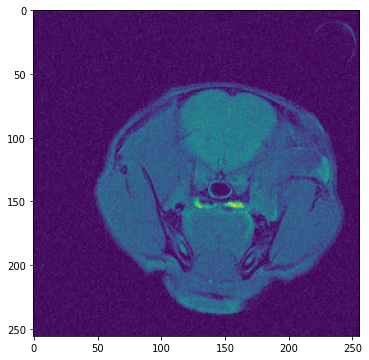

In [11]:
plt.subplots(1,1, figsize=(6, 6))
img = image_info.raw_image()
plt.imshow(img)

**Manual segmentation results in `.txt` files, which were fetched earlier along with images.**

*   
   2. Open the `lib/imagej_scripts/brain_segmentation_with_imagej.txt`, edit command for image opening according to [ImageJ macro guide] and [ImageJ macro functions list] to open your images (the function below comment `//IMAGE OPENING FUNCTION`). Initially it opens 32bit little-endian single channel 256x256, written as a C-array.
   1. Open imagej, load that file as imagej macro: `macros > install > imagej`
   1. Press `h` to open log window with the instructuions. follow the instructions.
   1. Run collect `collect_image_metadata.main()` (cell below)
   >you can find about metadata collection process and how to tune it with configuration editing if you run `help(collect_image_metadata.main)`
   
[ImageJ macro guide]: https://imagej.nih.gov/ij/developer/macro/macros.html#tools
[ImageJ macro functions list]: https://imagej.nih.gov/ij/developer/macro/functions.html

In [12]:
from mbs_lib.pipelines import collect_image_metadata
for i in {1, 2}:
    collect_image_metadata.main(infos[f"images_{i}"])

In [13]:
# how does metadata look?
meta = image_info.metadata()

for k, v in meta.items():
  print(k, ": ", v)

animal :  1
frame :  f14
hour :  3
lbbox :  [61, 123, 110, 147]
rbbox :  [61, 123, 148, 185]
rotation :  -7.7023


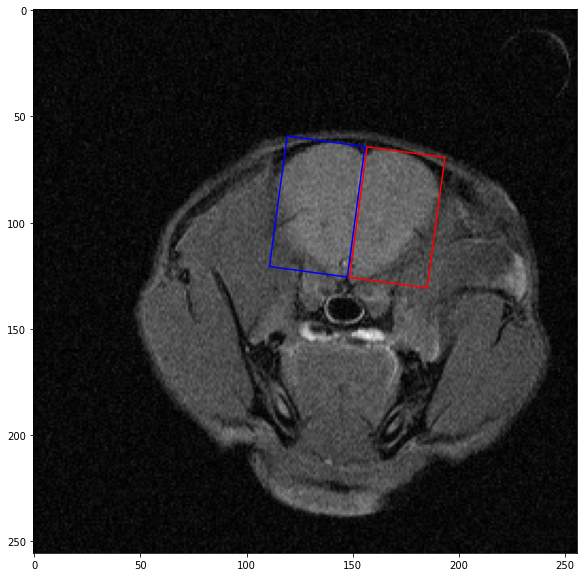

In [14]:
# let's visualize segmentation data. this one would be a bit trickier
from mbs_lib.utils.linalg_utils import bbox_to_coords, rotate_coords

meta = image_info.metadata()
rotation = meta["rotation"]

coords = {}
for side in "rl":
    coords[side] = bbox_to_coords(*meta[f"{side}bbox"], non_cycled=False)
    coords[side] = rotate_coords(coords[side], center=(127.5, 127.5), angle=-rotation, degrees=True)


plt.subplots(1,1, figsize = (10, 10))
plt.imshow(img, cmap="gray")
for side in "rl":
    plt.plot(coords[side][:, 0], coords[side][:, 1], c="blue" if side=="l" else "red")

## 4a. downloading atlas images ##
variables for downloading are stored in `ontology_folder_specification.yml` file inside ontology folder that you've created above.

1. Edit `atlas_id` and `svg_groups` (a table of them can be found [here](http://help.brain-map.org/display/api/Atlas+Drawings+and+Ontologies))

In [15]:
from mbs_lib.pipelines import download_svgs
download_svgs.download_default_ontology(infos["ontology"])

default ontology written to /content/example/ontology/onts/default.xml


2. Edit the `slice_coordinates` if you know the coordinates for the first slice and the last slice in the atlas. this allows you to download a list of slice ids and zip it with coordinate range using a script in the cell below (the table is just for utility purposes, you can skip this step).

In [16]:
download_svgs.download_slice_ids_table(infos["ontology"])

saved section ids to /content/example/ontology/slice_ids.txt


Now you have a very readable (for an xml) `default.xml` tree of structures for the atlas, and probably a tabulation-separated table of slice ids.
For each frame value in image names there should be an svg image with the same name. fill the ontology folder configuration  `svg_names_and_slice_ids` with pairs of `frame_field_value: slice_id`. run the script from the cell below to bulk-download the atlas vector images.

In [17]:
# we've renamed the files in ontology folder config 
# so that they wouldn't overwrite svgs downloaded with example
# feel free to explore the differences
download_svgs.download_svgs(infos["ontology"])

downloaded: /content/example/ontology/svgs/f14_downloaded.svg
downloaded: /content/example/ontology/svgs/f17_downloaded.svg


In [18]:
# # these svgs are too large to be propperly displayed inline (and I couldn't find simple way to scale them).
# # it is best to download them and view locally, although you can try to do this here:

# from IPython.display import display, SVG
# display(SVG(filename=infos["ontology"].svgs_folder() / f"f{frame}_downloaded.svg"))

In [19]:
# display(SVG(filename=infos["ontology"].svgs_folder() / f"f{frame}.svg"))

You can and need to manually edit the `.svg` masks with Inkscape, but note that some Inkscape functions can alter all xml attributes of the paths. structures for rendering are found by `structure_id` attributes of the paths, make sure, they are not deleted in the editing process.
1. I advise to compute mean of all images for each frame and put it into a corresponding svg (the rendering pipeline ignores visible objects that do not have `structure_id` attribute, so you can leave image there).
2. You **must** create a rectangle with xml attribute `structure_id='bbox'`, that will mark the border of the rendered masks (to edit xml attributes of objects from Inkscape, open the 'xml editor' tab.
3. It's a good idea to slightly adjust nodes of atlas structures to fit the contours of the brain.
4. Note that you can specify an arbitrary function to modify each mask right before the scan segmentation. Therefore you do need to flip/copy/crop the svg masks if only one hemisphere is covered and you need masks for both hemisperes, or otherwise. 

## 4b. rendering raster masks ##
For this one needs to edit `inkscape_executable_path` value in the ontology folder's configuration. 
The rendering pipeline uses image folder configuration `cropped_image_shapes` values for determining mask sizes.
Details about process can be found in `prerender_masks.main` function documentation. This process might take several hours, but is easily parallelized by calling pipeline from different processes for only a part of all frames.

In [20]:
# let's set up inkscape executable command:
file_backup(infos["ontology"].configuration_path())
modify_info_folder_config(
    info_instance = infos["ontology"], 
    keys = ["rendering_constants", "inkscape_executable"], 
    value = INKSCAPE_EXE,
)

In [21]:
from mbs_lib.pipelines import prerender_masks
# prerender_masks needs `ImageFolderInfo` configuration file to acqire shapes for masks.
# we will use masks prerendered for image folder 1 for both folder 1 and folder 2. 
prerender_masks.main(infos["ontology"], infos["images_1"], frames = ["f14", "f17"]) # we specify frames so that only these svgs will be used for mask generation

rendering for f14: 100%|█████████▉| 1326/1327 [00:24<00:00, 142.10it/s, Retina]               
Total found structures 78
rendering for f17: 100%|█████████▉| 1326/1327 [00:07<00:00, 143.67it/s, Retina]               
Total found structures 15


## 5. preprocessing scans ##
* Convert images to numpy native array format via `numpy.save()`, put them into `img` subfolder of the image folder.

* The pipeline called below uses `cropped_image_shapes` key of the configuration and `frame` field value in the image name as well as some metadata keys to crop and resize the images.

In [22]:
import numpy as np

def convert_raw_to_npy(ifi: IC.ImageFolderInfo, dtype="<i4", shape=(256, 256)):
    for img_info in ifi.raw_iter():
        img = img_info.raw_image(dtype=dtype, shape=shape)
        np.save(img_info.image_path(), img)


for i in {1, 2}:
    convert_raw_to_npy(infos[f"images_{i}"])

In [23]:
from mbs_lib.pipelines import crop_images

for i in {1, 2}:
    crop_images.main(infos[f"images_{i}"])

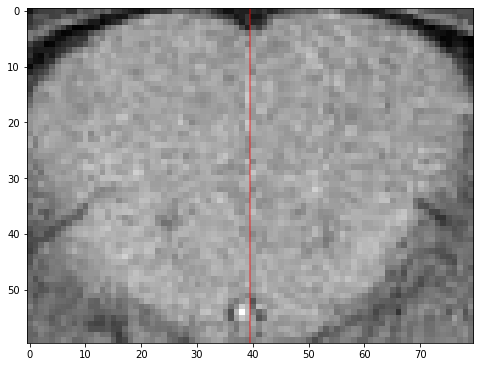

In [24]:
# ok, let's visualize cropped images
plt.subplots(1,1, figsize=(8,8))
cropped_image = image_info.cropped_image()
plt.imshow(cropped_image, cmap="gray")

plt.axvline(cropped_image.shape[1]/2-0.5, c="r", alpha=0.5) # image consists of two horizontally stacked halves, which were processed separately

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: UserWarning: No contour levels were found within the data range.
  from ipykernel import kernelapp as app


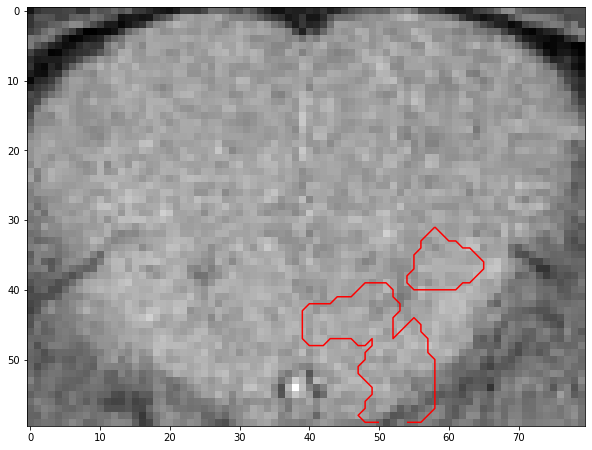

In [25]:
# and see how they coincide with masks
frame_ontology = infos["ontology"].ontology_info(f"f{frame}")

# mask_name = "Cortical Plate"
# mask_name = "Olfactory Areas"
# mask_name = "Piriform Area"
# mask_name = "Taenia Tecta"
mask_name = "Anterior Olfactory Nucleus"

mask_path_relative = frame_ontology.get_mask_filename(mask_name)
mask = frame_ontology.open_mask_relative(mask_path_relative)

plt.subplots(1, 1, figsize=(10,10))
plt.imshow(image_info.cropped_image(), cmap="gray")
plt.contour(mask, levels=0, colors="red") # for some reason it always throws warnings, although everything is fine with contours

To normalize image by intensity, we generate reference values and put them into metadata files. Later on you can choose which key to to use for image normalization. 

In [26]:
from mbs_lib.pipelines import generate_intensity_reference

for i in {1, 2}:
    generate_intensity_reference.main(infos[f"results_{i}"])

# this has added new entries into metadata files, we'll normalize image intensity, using some of them
meta = image_info.metadata()

for k, v in meta.items():
  print(k, ": ", v)

ER_animal_mean :  271995.73522308376
ER_animal_median :  270204.0
ER_animal_std :  78665.42763486702
ER_back_mean :  42728.71775366639
ER_back_median :  37380.0
ER_back_std :  29361.111021199813
ER_brain_mean :  357943.87785613537
ER_brain_median :  361945.0
ER_brain_std :  46094.87743763947
ER_head_mean :  256803.963901077
ER_head_median :  259257.0
ER_head_std :  73280.29362403404
ER_histogram_bg_peak :  32506.61196995466
ER_image_mean :  125292.97067260742
ER_image_median :  56657.0
ER_image_std :  122035.05764551918
animal :  1
frame :  f14
hour :  3
lbbox :  [61, 123, 110, 147]
rbbox :  [61, 123, 148, 185]
rotation :  -7.7023


## 6. fine anatomical segmentation
1. You need to specify a tabulation-separated table which contains names of images. Table header specifies, from which columns images fall into 'control' group and from which -- into the 'effect' group. images from the one row constitute a batch and are compared against each other. the `batch_for_comparison` pipeline can create this table. Note that one can easily edit this table in MS Excel/Libre Office, etc.
You can find about how to control pipeline behaviour through a result folder configuration in the `batch_for_comparison.main` description.

In [27]:
# change reference hour and title for debugging plots
for i in {1, 2}:
    file_backup(infos[f"results_{i}"].configuration_path())

    modify_info_folder_config(
        info_instance = infos[f"results_{i}"], 
        keys = ["batching", "comparison_reference_value"], 
        value = "3",
    )
    modify_info_folder_config(
        info_instance = infos[f"results_{i}"],
        keys = ["comparison", "plot_title"],
        value = "3h vs {hour}, frame {frame}. 1. smoothed p-value 2. mean relative intensity",
    )

In [28]:
from mbs_lib.pipelines import batch_for_comparison

for i in {1, 2}:
    batch_for_comparison.main(infos[f"results_{i}"])

In [29]:
# the batching procedure produces a `.csv` (text table) file
pd.read_csv(infos["results_1"].batches_path(), sep="\t", header=[0, 1])
# there are 2 batches (each row is a batch), each batch has a reference group(`is_reference=True`) and target group (`is_reference=False`)
# `animal` header is used for pairwise statistics, to match animals.
# values in the table are ids of animals (which are used to create `IC.ImageInfo` instances)

is_reference     False            ...     True                  
        animal         1         2  ...        4        5        6
0            0  24_1_f14  24_2_f14  ...  3_4_f14  3_5_f14  3_6_f14
1            1  24_1_f17  24_2_f17  ...  3_4_f17  3_5_f17  3_6_f17

[2 rows x 13 columns]

2. please read the `compare_and_segment.main` help for detalis on how to control it's behaviour with configuration file and some other files, that can be created in the `spec` subfolder of results folder.

In [30]:
# mask permutation for brain structure masks. this is optional
mask_permutation_script = """
import numpy as np

def mask_permutation(mask: "np.ndarray[bool]") -> "np.ndarray[bool]":
    # flip masks horizontally
    return np.flip(mask, axis = 1)
"""

for i in {1, 2}:
    with infos[f"results_{i}"].mask_permutation_path().open("wt") as script_file:
        script_file.write(mask_permutation_script)


In [31]:
# list of structures for the segmentation. this is optional
structure_list = [
    "Main Olfactory Bulb",
    "Main Olfactory Bulb Glomerular Layer",
    "Main Olfactory Bulb Granule Layer",
    "Main Olfactory Bulb Outer Plexiform Layer",
    "Main Olfactory Bulb Inner Plexiform Layer",
    "Main Olfactory Bulb Mitral Layer",

    "Lateral Olfactory Tract General",
    "Anterior Olfactory Nucleus",
    "Anterior Olfactory Nucleus Lateral Part",
    "Piriform Area",
    "Entorhinal Area",
    "Cortical Amygdalar Area",
    "Olfactory Tubercle",
    "Piriform-Amygdalar Area",
]


for i in {1, 2}:
    with infos[f"results_{i}"].structure_list_path().open("wt") as list_file:
        list_file.write("\n".join(structure_list))

In [32]:
from mbs_lib.pipelines import compare_and_segment

for i in {1, 2}:
    print(f"processing: results_{i}")
    compare_and_segment.main(infos[f"results_{i}"])

processing: results_1


  0%|          | 0/2 [00:00<?, ?it/s, 0]/content/zudanievil-MiceBrainMriSegmentation/mbs_lib/pipelines/compare_and_segment.py:185: UserWarning: No contour levels were found within the data range.
  axs[0].contour(structure_mask, **spec['contour_kwargs'])
/content/zudanievil-MiceBrainMriSegmentation/mbs_lib/pipelines/compare_and_segment.py:186: UserWarning: No contour levels were found within the data range.
  axs[1].contour(structure_mask, **spec['contour_kwargs'])


processing: results_2


3. segmentation results are saved into a temporary folder to save RAM and allow parallel execution (by running several processes and supplying `batch_range` argument to  `compare_and_segment.main`). Because of this design choice, segmentation results' pieces are aggregated by a separate function. You also need to delete temp folder yourself.

In [33]:
for i in {1, 2}:
    compare_and_segment.collect_segmentation_results(infos[f"results_{i}"])
    # rmdir_rec(infos[f"results_{i}"].segmentation_temp())

**Lets's look at some results**

In [34]:
# @markdown `def png_to_fig(path: str, figsize: (float, float) = (16, 8)) -> "matplotlib.figure.Figure"`

def png_to_fig(path: str, figsize: (float, float) = (16, 8)) -> "matplotlib.figure.Figure":
    img = imread(path)
    fig, ax = plt.subplots(1,1, figsize=figsize)
    _ = ax.imshow(img)
    _ = ax.axis("off")
    return fig

The pictures below were mostly meant for exploration & debugging.

The left one is an The left one is an array of p-values from the comparison of target and control groups.
Bright yellow area represents pixels that are significantly different between groups. 
p-values were inversed (1-pval), smoothed with gaussian blur and then inversed again, to favor large regions of high and low p-values with smooth transition:
 $Pval_1 = 1 - Gaussian\_blur(1 - Pval_0) $

The right picture is animalwise difference of images with corrected intensities
that were averaged across animals: 
$$\Delta I = {{\sum_{animals} (N(I^{target}_{animal}) - N(I^{control}_{animal})) } \over {N_{animals}}}$$ 
where I are intensities (pixel values), N is a correction function, that accounts for magnetic field inhomogenity, etc. 
Areas where Itarget > Icontrol are colored in red, where Icontol > Itarget -- in blue. 

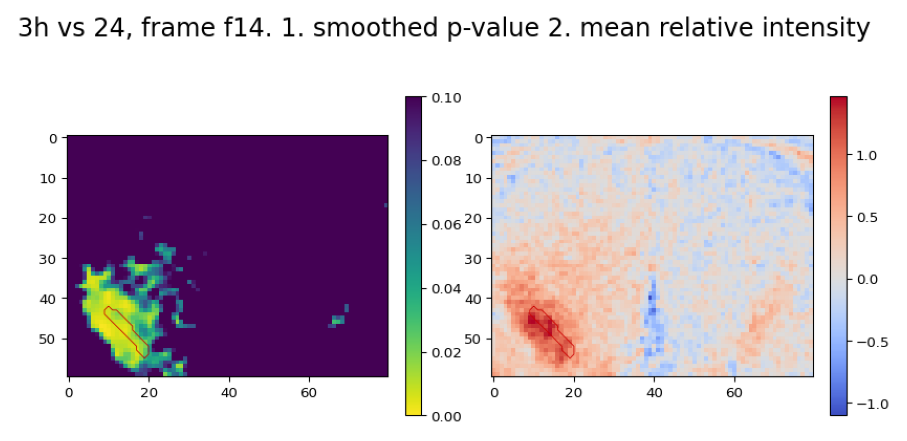

In [35]:
p = "/content/example/results_1/plots/root/fiber tracts/cm/In/lotg/Lateral Olfactory Tract General f14 at 24h.png"
png_to_fig(p).show()
# it can be clearly seen that all the pixels that are different between 3h pi and 24h pi are grouped along olfactory tract (red contour)

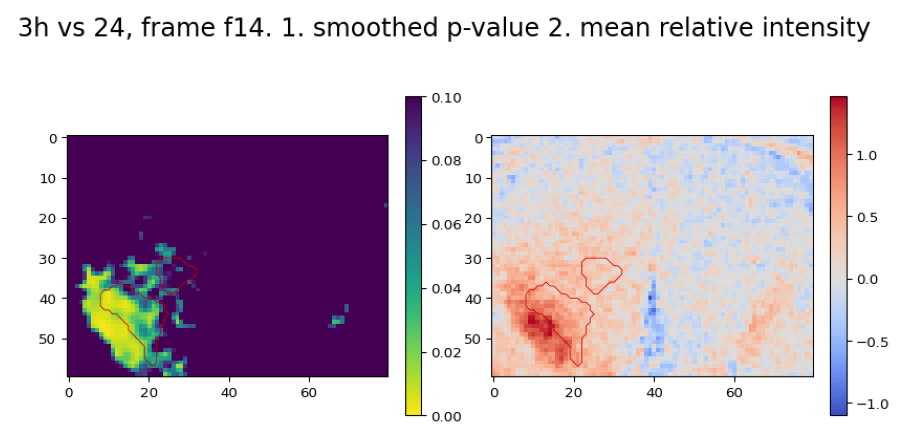

In [36]:
p = "/content/example/results_1/plots/root/grey/CH/CTX/CTXpl/OLF/PIR/Piriform Area f14 at 24h.png"
png_to_fig(p).show()

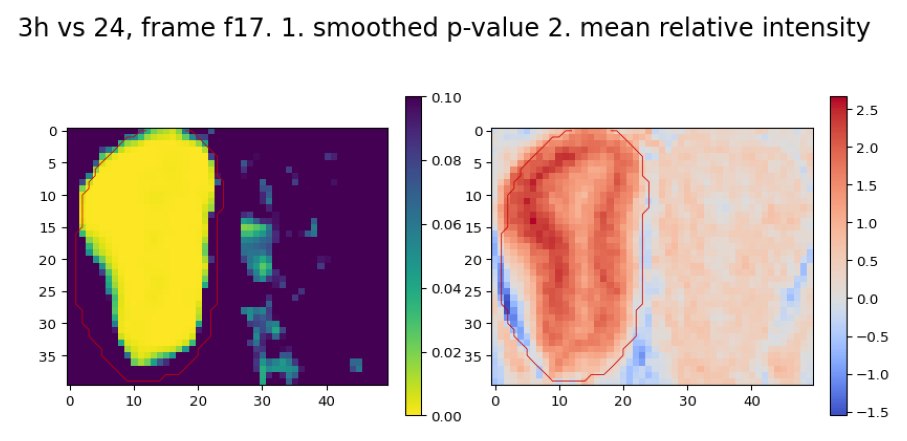

In [37]:
p = "/content/example/results_1/plots/root/grey/CH/CTX/CTXpl/OLF/MOB/Main Olfactory Bulb f17 at 24h.png"
png_to_fig(p).show()

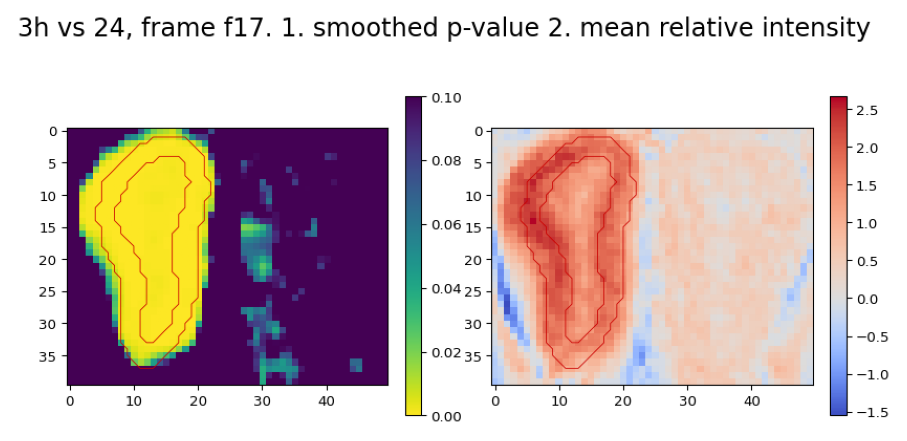

In [38]:
p = "/content/example/results_1/plots/root/grey/CH/CTX/CTXpl/OLF/MOB/MOBopl/Main Olfactory Bulb Outer Plexiform Layer f17 at 24h.png"
png_to_fig(p).show()

## 7. aftermath
There are some scripts for processing the results table. Consult with their descriptions to understand what do they do.
also there is an execute_all script, that just calls them in a logical order (some scripts depend on each other). They also use configuration for the results folder.

In [39]:
from mbs_lib.pipelines import combine_results


summary_path = working_dir / "summary.txt"

use_structures = None

combine_results.main(
    srfis = [infos[f"results_{i}"] for i in {1, 2}],
    save_path = summary_path,
    result_namer = lambda folder_name: {"group": int(folder_name.split("_")[1])},
    structures = use_structures,
)

In [40]:
def wrangle_summary(t: pd.DataFrame) -> pd.DataFrame:
    _hour = "hour"
    t.set_index(["group", "structure", "hour", "frame", "animal"], inplace=True)
    sign_px = (t["px (p <0.05)"] / t["px (p <1)"] * 100).unstack(_hour)
    t = t['mean (p <1)'].unstack(_hour)
    t['%sign px'] = sign_px.apply(np.max, axis=1)
    return t

wrangled_summary = working_dir / "wrangled_summary.txt"
table = wrangle_summary(pd.read_csv(summary_path, sep='\t'))
table.to_csv(wrangled_summary, sep="\t")

In [70]:
t1 = table[table["%sign px"] > 5]\
    .reset_index()\
    .set_index(["structure", "group", "frame", "animal"])
t1

hour                                                  3        24   %sign px
structure                  group frame animal                               
Anterior Olfactory Nucleus 1     f14   1       0.886310  1.086082  15.151515
                                       2       1.001193  1.157073  15.151515
                                       3       0.860200  1.292423  15.151515
                                       4       0.975791  1.423823  15.151515
                                       5       0.947356  1.189467  15.151515
...                                                 ...       ...        ...
Piriform Area              2     f14   2       0.975124  1.491166  43.093923
                                       3       0.815659  0.871139  43.093923
                                       4       0.961427  1.503516  43.093923
                                       5       0.841327  1.257054  43.093923
                                       6       0.866085  1.561422  43.093923

[96 rows x 3 columns]

In [86]:
t1.index.get_level_values("structure").unique()

Index(['Anterior Olfactory Nucleus', 'Lateral Olfactory Tract General',
       'Main Olfactory Bulb', 'Main Olfactory Bulb Glomerular Layer',
       'Main Olfactory Bulb Granule Layer',
       'Main Olfactory Bulb Inner Plexiform Layer',
       'Main Olfactory Bulb Outer Plexiform Layer', 'Piriform Area'],
      dtype='object', name='structure')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: PerformanceWarning: indexing past lexsort depth may impact performance.


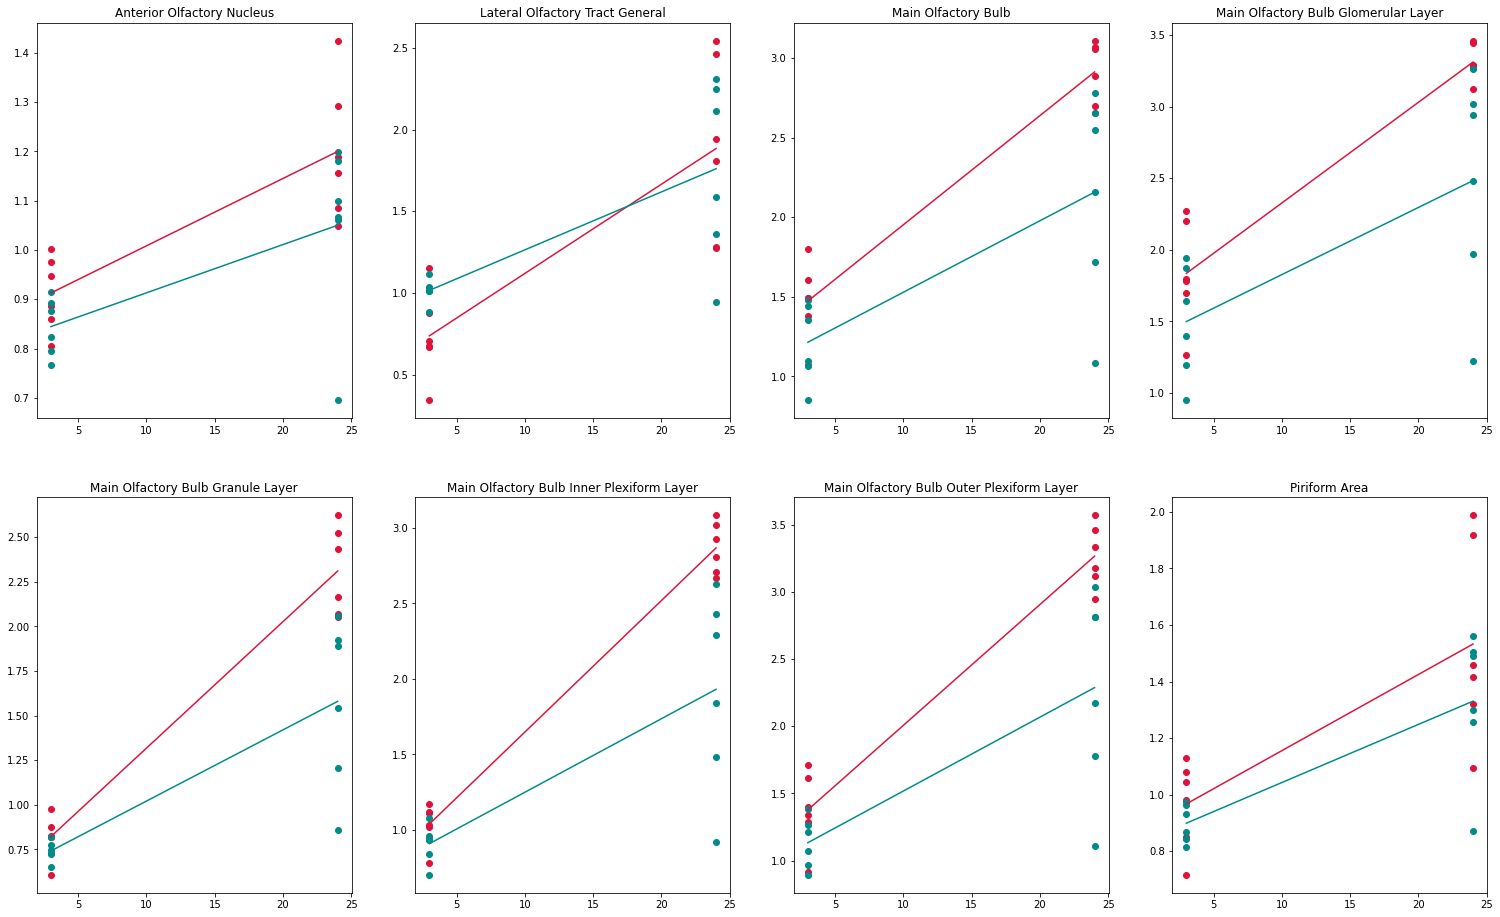

In [99]:
# we can do simple visualization of the differences in group dynamics
structures = [
    'Anterior Olfactory Nucleus', 
    'Lateral Olfactory Tract General',
    'Main Olfactory Bulb', 'Main Olfactory Bulb Glomerular Layer',
    'Main Olfactory Bulb Granule Layer',
    'Main Olfactory Bulb Inner Plexiform Layer',
    'Main Olfactory Bulb Outer Plexiform Layer', 
    'Piriform Area'
]
groups = [1, 2]
hours = [3, 24]
colors = ["crimson", "darkcyan"]

fig, axs = plt.subplots(2, 4, figsize=(26, 16))
axs = axs.flatten()

for i, structure in enumerate(structures):
    axs[i].set_title(structure)
    for group in groups:
        temp = t1.loc[structure, group]
        axs[i].plot(temp[hours].mean(), c=colors[group-1])
        for hour in hours:
            axs[i].scatter([hour]*len(temp), temp[hour], c=colors[group-1])